In [ ]:
import pandas as pd
import pickle

import sys
sys.path.append('C:\\Users\\Tim\\PycharmProjects\\625.687\src') # your local repo here

path = "C:\\Users\\Tim\\Desktop\\MillionSongSubsetMillionSongSubset_dataframe_test.pkl" # your local data here
big_path = "C:\\Users\\Tim\\Documents\\MillionSongSubset_dataframe_test.pkl"
df = pickle.load(open(big_path, "rb"))

In [43]:
import msd_utils

# Set up dataframe 
subdf = df[["year", "segments_pitches"]]
subdf = subdf[subdf["year"] != 0][:1000]

# Featurize pitch data
pitch_features = []
for index, row in subdf.iterrows():
    row_feats = msd_utils.vectorize_segments_pitches(row["segments_pitches"])
    pitch_features.append(row_feats)
subdf["pitch_features"] = pitch_features

In [44]:
import Metrics
import numpy as np

mf = Metrics.Metric() # metric factory
metrics_df = []

# Compute a square matrix of scores (every song against every song)
for index1, row1 in subdf.iterrows():
    metric_scores = []
    for index2, row2 in subdf.iterrows():
        score = mf.L_2_norm(row1["pitch_features"], row2["pitch_features"])
        #score = score[0][0]  # need to change cosine_sim metric to return a float, not a [[float]]...
        metric_scores.append(score)
    metrics_df.append(metric_scores)
    
metrics_df = np.asarray(metrics_df)

In [45]:
from msd_utils import compute_metric_matrix

l1_dmatrix = compute_metric_matrix(subdf, "L_1_norm")
l2_dmatrix = compute_metric_matrix(subdf, "L_2_norm")
linf_dmatrix = compute_metric_matrix(subdf, "L_inf_norm")
cosine_dmatrix = compute_metric_matrix(subdf, "cosine_similarity")

dmatrices = [
    l1_dmatrix,
    l2_dmatrix,
    linf_dmatrix,
    cosine_dmatrix
]

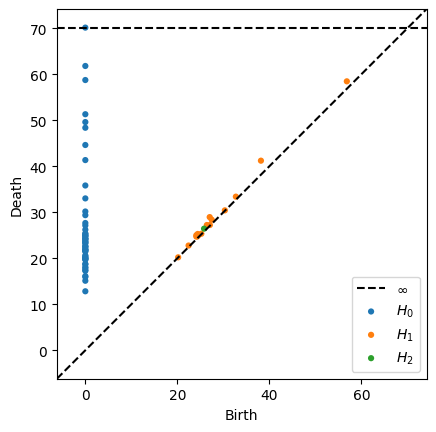

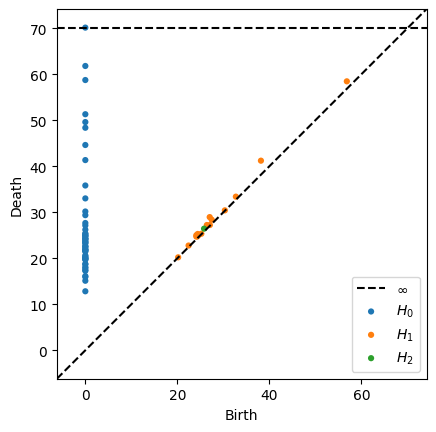

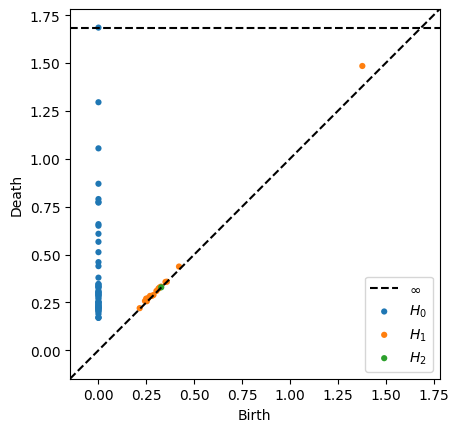

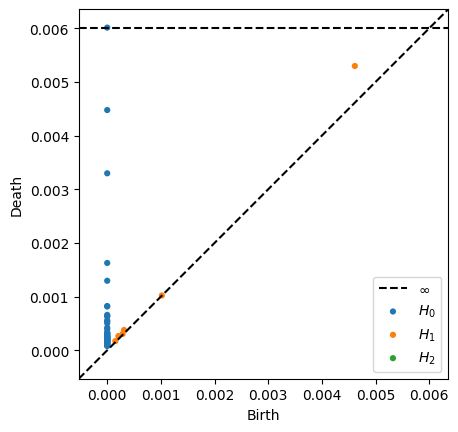

In [46]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np

for matrix in dmatrices:
    matrix = np.asarray(matrix)
    res = ripser(matrix, distance_matrix=True, maxdim=2)
    plot_diagrams(res['dgms'], show=True)

In [49]:
# Import the class
from IPython.core.display import HTML
import kmapper as km

# Initialize
mapper = km.KeplerMapper(verbose=1)

# Fit to and transform the data
matrix_metrics_df = np.asarray(matrix_metrics_df)
projected_data = mapper.fit_transform(matrix_metrics_df, projection=[0,1], distance_matrix=True) # X-Y axis

# Create dictionary called 'graph' with nodes, edges and meta-information
graph = mapper.map(projected_data, matrix_metrics_df, cover=km.Cover(n_cubes=10))

# Visualize it
html = mapper.visualize(graph, path_html="make_circles_keplermapper_output.html",
                 title="make_circles(n_samples=5000, noise=0.03, factor=0.3)")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: True
	Scalers: MinMaxScaler()
..Projecting on data shaped (52, 52)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (52, 52) using lens shaped (52, 2)

Creating 100 hypercubes.

Created 20 edges and 10 nodes in 0:00:00.024985.
Wrote visualization to: make_circles_keplermapper_output.html


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

X = np.array([[1, 2], [2, 2], [2, 3],
              [8, 7], [8, 8], [25, 80]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
clustering.labels_

def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    


In [ ]:
import matplotlib.pyplot as plt
X = metrics_df
plt.scatter(X[:,0], X[:,1])
plt.show()

In [ ]:
X[:,0]

In [ ]:
X[:,1]

In [31]:
import collections
import numpy as np

def matrix_featurize_segments_pitches(pitches_vector):
    """
    Each column represents a pitch, each row a summary of the time series data (256x12)
    """
    # Space out the range [0,1] to 256 equally separated values
    bin_values = np.linspace(0, 1, 256)
    tone_bins = {}
    for tone in range(12):
        tone_bins[tone] = collections.defaultdict(float)

    # Iterate through segments_pitches field and generate 2-D pitches frequency histogram
    for entry in pitches_vector:  # vector of 12 semitones (A->G#)
        for i in range(12):  # for each tone
            pitch_idx = 0
            while entry[i] >= bin_values[pitch_idx]:  # find the bin for that tone's value,
                if pitch_idx == 31:
                    break
                pitch_idx += 1
            tone_bins[i][pitch_idx] += 1  # then save it to tone_bins

    # Now, collapse the 2-D histogram into a 256-length feature vector
    return_matrix = []
    normalization_factor = len(pitches_vector) # normalize, since more entries -> higher values due to length
    for j in range(256):
        return_vector = []
        for i in range(12):
            return_vector.append(tone_bins[i][j] / normalization_factor)
        return_matrix.append(return_vector)
    return np.asarray(return_matrix)

# Featurize pitch data
matrix_pitch_features = []
for index, row in subdf.iterrows():
    matrix_row_feats = matrix_featurize_segments_pitches(row["segments_pitches"])
    matrix_pitch_features.append(matrix_row_feats)
subdf["matrix_pitch_features"] = matrix_pitch_features

# Compute a square matrix of scores (every song against every song)
matrix_metrics_df = []
for index1, row1 in subdf.iterrows():
    metric_scores = []
    for index2, row2 in subdf.iterrows():
        score = mf.spectral_correlation_pseudometric(row1["matrix_pitch_features"], row2["matrix_pitch_features"])
        metric_scores.append(score)
    matrix_metrics_df.append(metric_scores)
    
matrix_metrics_df = np.asarray(matrix_metrics_df)

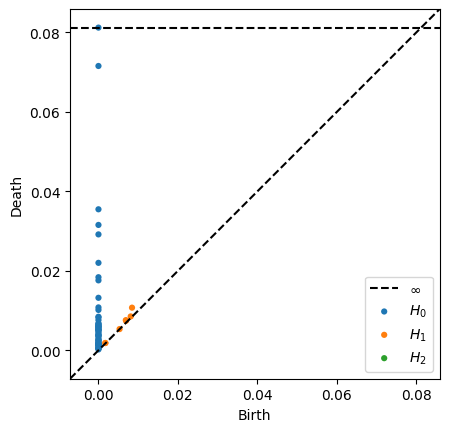

In [33]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np

res = ripser(matrix_metrics_df, distance_matrix=True, maxdim=2)
plot_diagrams(res['dgms'], show=True)

In [50]:
len(matrix_metrics_df)

52

In [ ]:
cluster

As one increases a threshold, at what scale do we observe changes in some representation of the data?

0d persistent homology is tracking when these balls intersect. More specifically, it records when the ball in one connected component first intersects a ball of a different connected component.

Thus, there is a special significance on persistence diagrams to gaps between (birth, death) pairs closer to 0 and any points above. In particular, this gap signifies the extent to which data is clustered relative to its noisiness. For the picture above, a larger gap between that top persistence value and the lower persistence values would be generated if we further separated the two noisy clusters. Similarly, if we pushed the noisy clusters closer together, that gap would shrink.

at very low persistence values, there are brief instances of loops forming early on, the most notable being around the location (-1, 0) in the figure on the left. These loops have a small radius and are thus quickly filled in by the expanding disks, leading to death values close to their birth values and therefore creating points on the persistence diagram close to the diagonal.

So, persistence of a homology is its proximity to the upper left corner

Future work - signal persistent homologies, ie homology analysis over sequential data

https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489 

In [ ]:
radius = 120 # picked a value after looking at the L2 outputs

# Group together elements which, for a given radius, have metric values less than some radius
# Using matrix indices to save groups; indices should stil align to position in subdf 

def find_balls(dmatrix, radius):
    balls = set()
    for i in range(len(dmatrix)):
        ball_centered_around_i = set()
        for j in range(len(dmatrix)):
            if dmatrix[i][j] <= radius: # Changed this to be inclusive, so that radius 0 returns all vertices. Hoping this doesn't break anything!
                ball_centered_around_i.add(j)
        ball = tuple(sorted(ball_centered_around_i))
        balls.add(ball)
    return balls

balls = find_balls(metrics_df , 120)

In [ ]:
len(balls)

In [ ]:
""" Graveyard """


def forms_topology(set_of_sets):
    """
    Hacky/lazy check to find out whether a given set of sets is likely to be a topology
    I was hoping that the elements generated by a given metric would metrize up into a topology, 
    but it doesn't look like that's (always) the case
    """
    x_in_topology = False
    closed_under_intersection = True
    closed_under_union = True
    
    X = set()
    for subset in set_of_sets:
        
        # Build X
        for element in subset:
            X.add(element)
        
        # Check intersection, union (lazy - only looks at pairs, not combos)
        for any_other_subset in set_of_sets:
            intersect = set([x for x in subset if x in any_other_subset])
            union = set(subset)
            for x in any_other_subset:
                union.add(x)
            intersect = tuple(sorted(intersect))
            union = tuple(sorted(union))
            if not intersect in set_of_sets and not intersect == ():
                closed_under_intersection = False
            elif not union in set_of_sets:
                closed_under_union = False
    
    # Check X in set
    if tuple(sorted(X)) in set_of_sets:
        x_in_topology = True
        
    is_topology = x_in_topology and closed_under_intersection and closed_under_union
    return is_topology

# Unfortunately, the elements don't form a topology. Not a problem, but it would've been cool
forms_topology(elements)
